Imports

In [1]:
import pandas 
import numpy
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


from pathlib import Path

folder = Path("Data")
folder.mkdir(parents=True, exist_ok=True)

Setting data

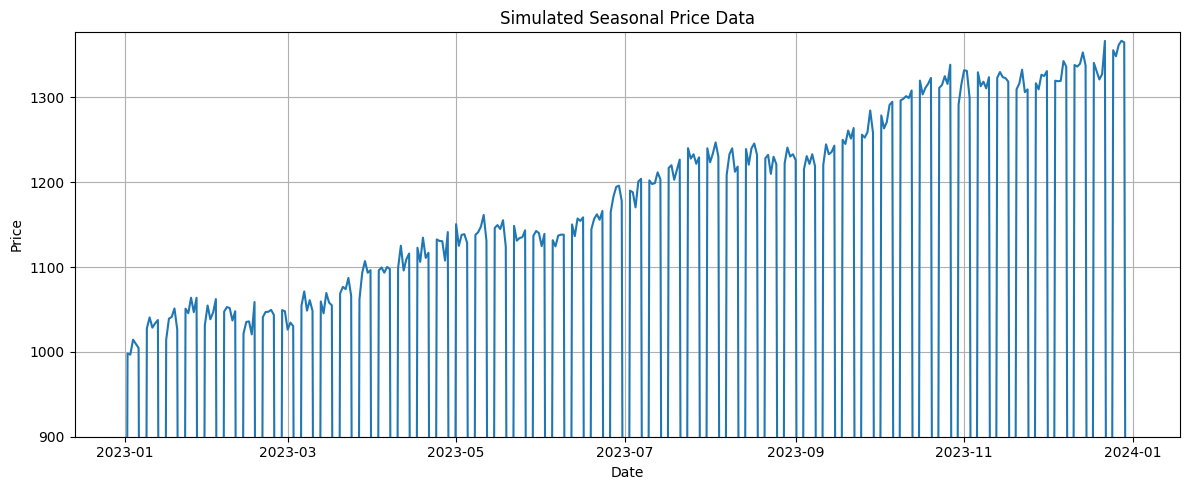

In [2]:
# Configuration
start_date = "2023-01-01"
end_date = "2023-12-31"
zero_on_weekends = True  # Set True if you want prices to be 0 on weekends

# Generate date range
dates = pandas.date_range(start=start_date, end=end_date, freq="D")
seasonal_plus_linear_growth_dataframe = pandas.DataFrame({"date": dates})
seasonal_plus_linear_growth_dataframe["day_of_year"] = seasonal_plus_linear_growth_dataframe["date"].dt.dayofyear
seasonal_plus_linear_growth_dataframe["day_of_week"] = seasonal_plus_linear_growth_dataframe["date"].dt.dayofweek  # 0=Mon, ..., 6=Sun

# Generate seasonal pattern (using sine curve)
# Example: simulate higher prices in middle of year (summer)
seasonal_pattern = 1000 + 20 * numpy.sin(8 * numpy.pi * seasonal_plus_linear_growth_dataframe["day_of_year"] / 365) #

# Add some trend (e.g., slow increase over time)
trend = seasonal_plus_linear_growth_dataframe["day_of_year"] * 1

# Add random noise
noise = numpy.random.normal(0, 10.0, size=len(seasonal_plus_linear_growth_dataframe))

# Final price = seasonality + trend + noise
seasonal_plus_linear_growth_dataframe["price"] = seasonal_pattern + trend + noise

# Optionally zero out weekends
if zero_on_weekends:
    seasonal_plus_linear_growth_dataframe.loc[seasonal_plus_linear_growth_dataframe["day_of_week"] >= 5, "price"] = 0

# Plot result
plt.figure(figsize=(12, 5))
plt.plot(seasonal_plus_linear_growth_dataframe["date"], seasonal_plus_linear_growth_dataframe["price"])
plt.title("Simulated Seasonal Price Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.ylim(900, seasonal_plus_linear_growth_dataframe["price"].max() + 10)
plt.tight_layout()
plt.show()

# Save to CSV
seasonal_plus_linear_growth_dataframe[["date", "price"]].to_csv("Data/seasonal_plus_linear_growth.csv", index=False)

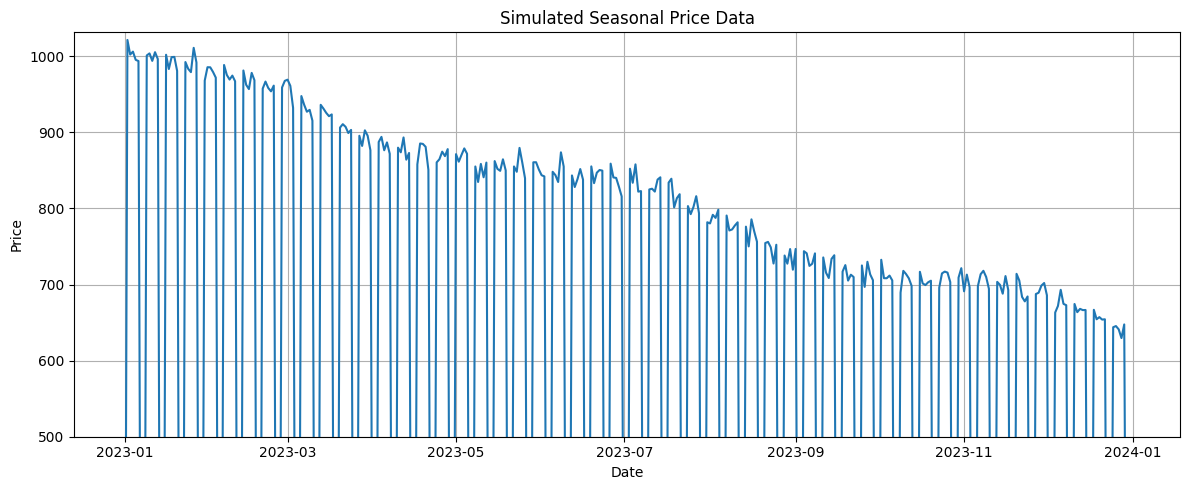

In [3]:
# Configuration
start_date = "2023-01-01"
end_date = "2023-12-31"
zero_on_weekends = True  # Set True if you want prices to be 0 on weekends

# Generate date range
dates = pandas.date_range(start=start_date, end=end_date, freq="D")
seasonal_plus_linear_growth_dataframe = pandas.DataFrame({"date": dates})
seasonal_plus_linear_growth_dataframe["day_of_year"] = seasonal_plus_linear_growth_dataframe["date"].dt.dayofyear
seasonal_plus_linear_growth_dataframe["day_of_week"] = seasonal_plus_linear_growth_dataframe["date"].dt.dayofweek  # 0=Mon, ..., 6=Sun

# Generate seasonal pattern (using sine curve)
# Example: simulate higher prices in middle of year (summer)
seasonal_pattern = 1000 + 20 * numpy.sin(5 * numpy.pi * seasonal_plus_linear_growth_dataframe["day_of_year"] / 365) #

# Add some trend (e.g., slow increase over time)
trend = seasonal_plus_linear_growth_dataframe["day_of_year"] * 1

# Add random noise
noise = numpy.random.normal(0, 10.0, size=len(seasonal_plus_linear_growth_dataframe))

# Final price = seasonality + trend + noise
seasonal_plus_linear_growth_dataframe["price"] = seasonal_pattern - trend + noise

# Optionally zero out weekends
if zero_on_weekends:
    seasonal_plus_linear_growth_dataframe.loc[seasonal_plus_linear_growth_dataframe["day_of_week"] >= 5, "price"] = 0

# Plot result
plt.figure(figsize=(12, 5))
plt.plot(seasonal_plus_linear_growth_dataframe["date"], seasonal_plus_linear_growth_dataframe["price"])
plt.title("Simulated Seasonal Price Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.ylim(500, seasonal_plus_linear_growth_dataframe["price"].max() + 10)
plt.tight_layout()
plt.show()

# Save to CSV
seasonal_plus_linear_growth_dataframe[["date", "price"]].to_csv("Data/seasonal_plus_linear_decrease.csv", index=False)

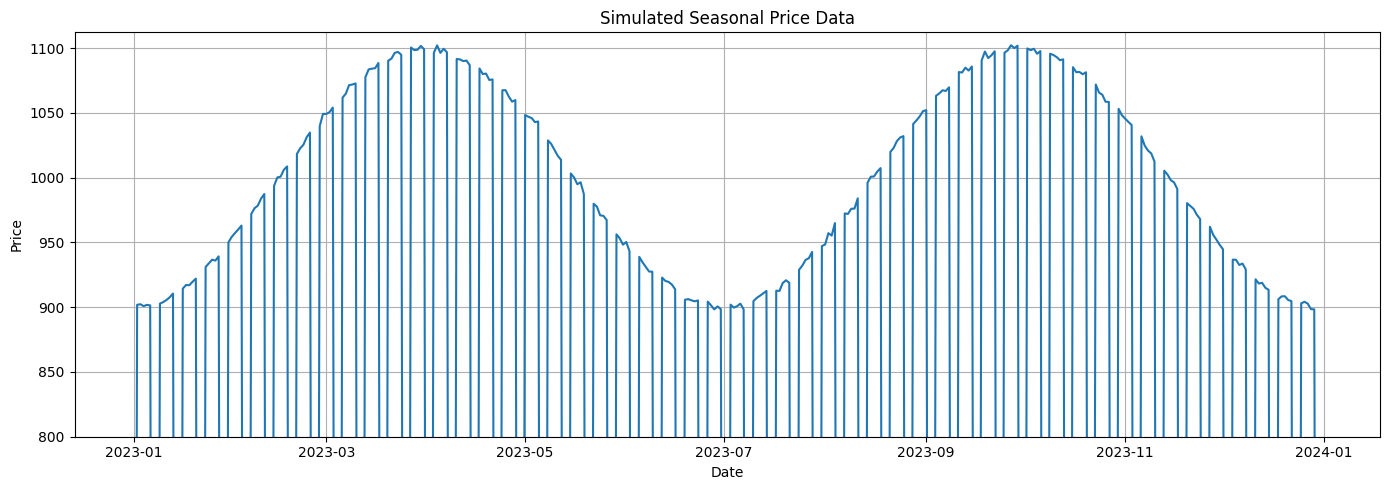

In [4]:
# Configuration
start_date = "2023-01-01"
end_date = "2023-12-31"
zero_on_weekends = True  # Set True if you want prices to be 0 on weekends

# Generate date range
dates = pandas.date_range(start=start_date, end=end_date, freq="D")
seasonal__dataframe = pandas.DataFrame({"date": dates})
seasonal__dataframe["day_of_year"] = seasonal__dataframe["date"].dt.dayofyear
seasonal__dataframe["day_of_week"] = seasonal__dataframe["date"].dt.dayofweek  # 0=Mon, ..., 6=Sun

# Generate seasonal pattern (using sine curve)
# Example: simulate higher prices in middle of year (summer)
shift_days = 45
seasonal_pattern = 1000 + 100 * numpy.sin(4 * numpy.pi * (seasonal__dataframe["day_of_year"] - shift_days) / 365)

# Add random noise
noise = numpy.random.normal(0, 2.0, size=len(seasonal__dataframe))

# Final price = seasonality + trend + noise
seasonal__dataframe["price"] = seasonal_pattern + noise

# Optionally zero out weekends
if zero_on_weekends:
    seasonal__dataframe.loc[seasonal__dataframe["day_of_week"] >= 5, "price"] = 0

# Plot result
plt.figure(figsize=(14, 5))
plt.plot(seasonal__dataframe["date"], seasonal__dataframe["price"])
plt.title("Simulated Seasonal Price Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.ylim(800, seasonal__dataframe["price"].max() + 10)
plt.show()

# Save to CSV
seasonal__dataframe[["date", "price"]].to_csv("Data/seasonal_price_data.csv", index=False)

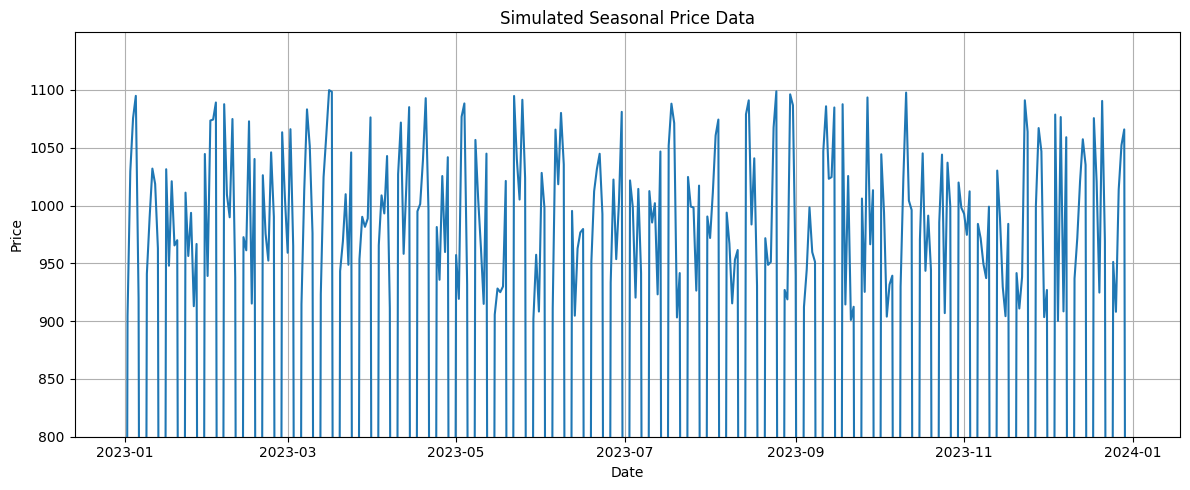

In [5]:
# Configuration
start_date = "2023-01-01"
end_date = "2023-12-31"
zero_on_weekends = True  # Set True if you want prices to be 0 on weekends

# Generate date range
dates = pandas.date_range(start=start_date, end=end_date, freq="D")
seasonal_plus_linear_growth_dataframe = pandas.DataFrame({"date": dates})
seasonal_plus_linear_growth_dataframe["day_of_year"] = seasonal_plus_linear_growth_dataframe["date"].dt.dayofyear
seasonal_plus_linear_growth_dataframe["day_of_week"] = seasonal_plus_linear_growth_dataframe["date"].dt.dayofweek  # 0=Mon, ..., 6=Sun

trend = numpy.random.uniform(-0.1, 0.1, size=len(dates))

prices = [numpy.float64(1000)]

for r in trend[1:]:
    new_price = prices[0] * (1 + r)
    prices.append(new_price)

seasonal_plus_linear_growth_dataframe['price'] = prices

# Optionally zero out weekends
if zero_on_weekends:
    seasonal_plus_linear_growth_dataframe.loc[seasonal_plus_linear_growth_dataframe["day_of_week"] >= 5, "price"] = 0


# # Plot result
plt.figure(figsize=(12, 5))
plt.plot(seasonal_plus_linear_growth_dataframe["date"], seasonal_plus_linear_growth_dataframe["price"])
plt.title("Simulated Seasonal Price Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.ylim(800, seasonal_plus_linear_growth_dataframe["price"].max() + 50)
plt.tight_layout()
plt.show()

# # Save to CSV
seasonal_plus_linear_growth_dataframe[["date", "price"]].to_csv("Data/linear_random_deviation.csv", index=False)

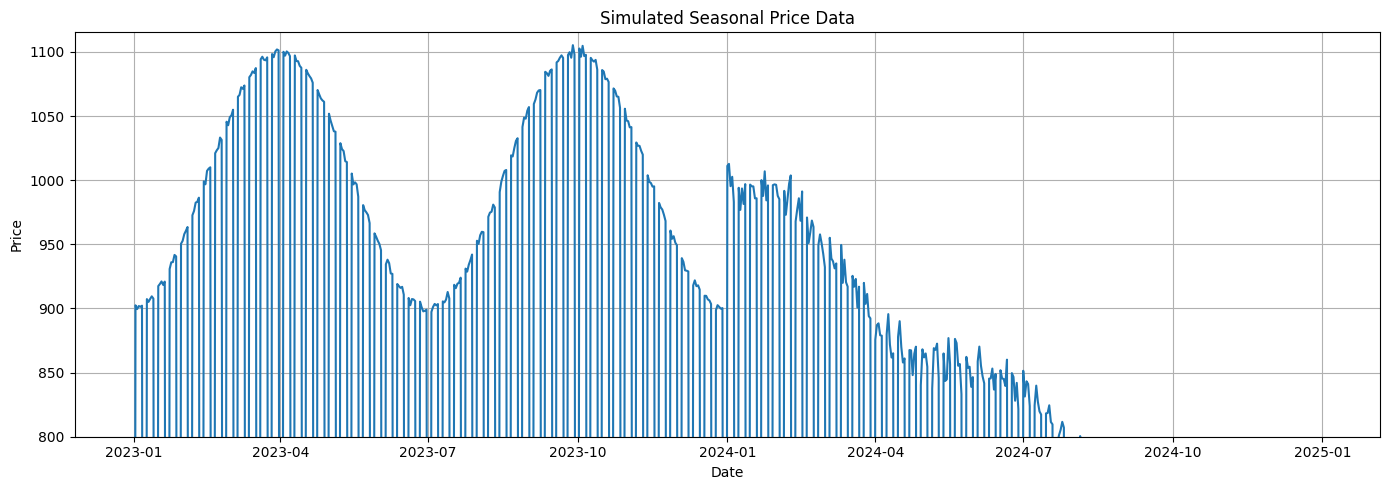

In [6]:
#Banduka dataset
# Configuration
start_date = "2023-01-01"
end_date = "2023-12-31"
zero_on_weekends = True  # Set True if you want prices to be 0 on weekends

# Generate date range
dates = pandas.date_range(start=start_date, end=end_date, freq="D")
seasonal__dataframe = pandas.DataFrame({"date": dates})
seasonal__dataframe["day_of_year"] = seasonal__dataframe["date"].dt.dayofyear
seasonal__dataframe["day_of_week"] = seasonal__dataframe["date"].dt.dayofweek  # 0=Mon, ..., 6=Sun

# Generate seasonal pattern (using sine curve)
# Example: simulate higher prices in middle of year (summer)
shift_days = 45
seasonal_pattern = 1000 + 100 * numpy.sin(4 * numpy.pi * (seasonal__dataframe["day_of_year"] - shift_days) / 365)

# Add random noise
noise = numpy.random.normal(0, 2.0, size=len(seasonal__dataframe))

# Final price = seasonality + trend + noise
seasonal__dataframe["price"] = seasonal_pattern + noise

# Optionally zero out weekends
if zero_on_weekends:
    seasonal__dataframe.loc[seasonal__dataframe["day_of_week"] >= 5, "price"] = 0

dataset = seasonal__dataframe.copy()

start_date = "2024-01-01"
end_date = "2024-12-31"
zero_on_weekends = True  # Set True if you want prices to be 0 on weekends

# Generate date range
dates = pandas.date_range(start=start_date, end=end_date, freq="D")
seasonal_plus_linear_growth_dataframe = pandas.DataFrame({"date": dates})
seasonal_plus_linear_growth_dataframe["day_of_year"] = seasonal_plus_linear_growth_dataframe["date"].dt.dayofyear
seasonal_plus_linear_growth_dataframe["day_of_week"] = seasonal_plus_linear_growth_dataframe["date"].dt.dayofweek  # 0=Mon, ..., 6=Sun

# Generate seasonal pattern (using sine curve)
# Example: simulate higher prices in middle of year (summer)
seasonal_pattern = 1000 + 20 * numpy.sin(5 * numpy.pi * seasonal_plus_linear_growth_dataframe["day_of_year"] / 365) #

# Add some trend (e.g., slow increase over time)
trend = seasonal_plus_linear_growth_dataframe["day_of_year"] * 1

# Add random noise
noise = numpy.random.normal(0, 10.0, size=len(seasonal_plus_linear_growth_dataframe))

# Final price = seasonality + trend + noise
seasonal_plus_linear_growth_dataframe["price"] = seasonal_pattern - trend + noise

# Optionally zero out weekends
if zero_on_weekends:
    seasonal_plus_linear_growth_dataframe.loc[seasonal_plus_linear_growth_dataframe["day_of_week"] >= 5, "price"] = 0

dataset = pandas.concat([dataset, seasonal_plus_linear_growth_dataframe], axis=0, ignore_index=False)

plt.figure(figsize=(14, 5))
plt.plot(dataset["date"], dataset["price"])
plt.title("Simulated Seasonal Price Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.ylim(800, dataset["price"].max() + 10)
plt.show()

# Save to CSV
dataset[["date", "price"]].to_csv("Data/banduka_df.csv", index=False)

In [7]:
# df_300 = pandas.read_csv("Data/quality_controls2.csv")
# cols = ['frequency', 'costType', 'risk_id', 'created_at']
# df_300 = df_300[cols]
# df_300['date'] = pandas.to_datetime(df_300['created_at'])
# df_300['date'] = df_300['date'].dt.date


# unit_price = {
#     'finishing': 5,
#     'scrap':     50
# }
# df_300['unit_price'] = df_300['costType'].map(unit_price) # type: ignore
# df_300['price'] = df_300['frequency'] * df_300['unit_price']

# df_300 = (
#     df_300
#     .groupby(['date','risk_id'], as_index=False)['price']
#     .sum()
# )
# df_300 = df_300.set_index('date')

# df_risk1 = df_300[df_300['risk_id'] == 3]

In [8]:
from statsmodels.tsa.seasonal import STL

prices_dataframe = pandas.read_csv("Data/seasonal_price_data.csv")
prices_dataframe['date'] = pandas.to_datetime(prices_dataframe['date'])
prices_dataframe = prices_dataframe.set_index('date')
prices_dataframe = prices_dataframe[prices_dataframe.index.dayofweek < 5]


def season_trend_strength(series: pandas.Series, period: int):
    """Compute seasonal and trend strengths via STL."""
    stl = STL(series, period=period, robust=True).fit()
    resid = stl.resid
    seasonal = stl.seasonal
    trend = stl.trend

    var_resid = numpy.var(resid)
    var_season_plus_resid = numpy.var(resid + seasonal)
    var_trend_plus_resid = numpy.var(resid + trend)

    F_season = max(0, 1 - var_resid / var_season_plus_resid)
    F_trend  = max(0, 1 - var_resid / var_trend_plus_resid)
    
    # stl.plot()
    return F_season, F_trend

for name, per in [("Monthly", 30), ("Yearly", int(prices_dataframe.shape[0]/2)),("Quarter", 90)]:
    seasonal_strength,trend_strength = season_trend_strength(prices_dataframe, per)
    print(f"{name} seasonality strength (period={per}): {seasonal_strength:.2f}")
    print(f"{name} trend strength (period={per}): {trend_strength:.2f}")
    
# plt.figure(figsize=(12, 5))
# plt.plot(prices_dataframe.index, prices_dataframe["price"])
# plt.title("Simulated Seasonal Price Data")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.grid(True)
# # plt.ylim(800, prices_dataframe["price"].max() + 50)
# plt.tight_layout()
# plt.show()

Monthly seasonality strength (period=30): 0.12
Monthly trend strength (period=30): 0.98
Yearly seasonality strength (period=130): 1.00
Yearly trend strength (period=130): 0.00
Quarter seasonality strength (period=90): 0.69
Quarter trend strength (period=90): 0.20


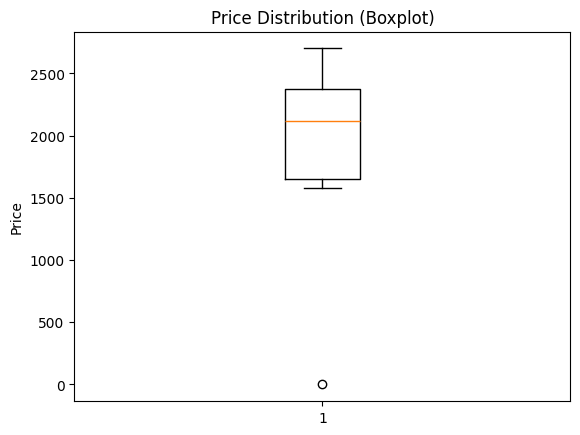

Lower outliers (below 173.25): 1
Upper outliers (above 2675.25): 1
Total clipped values: 2


In [ ]:
prices_dataframe = pandas.read_csv("Data/baza.csv")

Q1  = prices_dataframe['price'].quantile(0.25)
Q3  = prices_dataframe['price'].quantile(0.75)
IQR = Q3 - Q1

# define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

low_count  = (prices_dataframe['price'] <  lower_bound).sum()
high_count = (prices_dataframe['price'] >  upper_bound).sum()
total_outliers = low_count + high_count

plt.figure()
plt.boxplot(prices_dataframe['price'].dropna())
plt.title('Price Distribution (Boxplot)')
plt.ylabel('Price')
plt.show()

# clamp all values to [lower_bound, upper_bound]
prices_dataframe['price'] = prices_dataframe['price'].clip(lower=lower_bound, upper=upper_bound)



print(f"Lower outliers (below {lower_bound}): {low_count}")
print(f"Upper outliers (above {upper_bound}): {high_count}")
print(f"Total clipped values: {total_outliers}")

SES - Simple exponential smoothing

Total forecasted price: 19,798,199.75


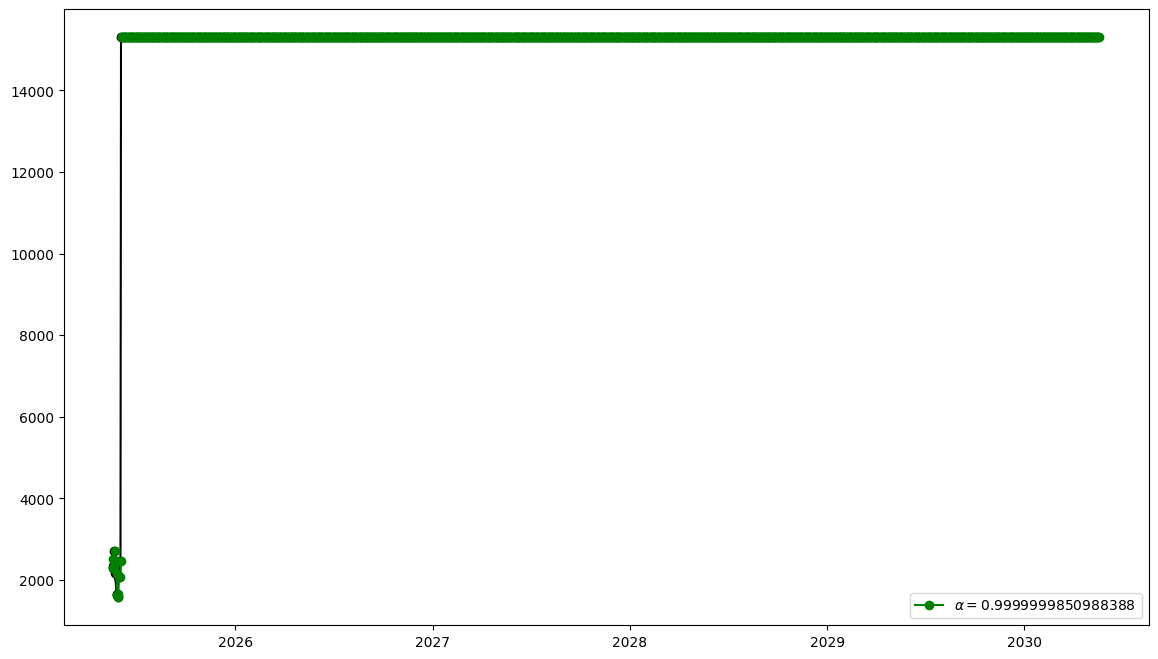

In [10]:
prices_dataframe = pandas.read_csv("Data/baza.csv")

min_date = prices_dataframe['date'].min()

project_start_date = datetime.strptime(min_date, "%Y-%m-%d")
project_end_date = project_start_date + pandas.DateOffset(years=5)

# Ensure datetime and set index
prices_dataframe['date'] = pandas.to_datetime(prices_dataframe['date'])
prices_dataframe = prices_dataframe.set_index('date')
current_date = prices_dataframe.index[-1]
count_excluding_end = pandas.bdate_range(start=current_date, end=project_end_date).size
train = prices_dataframe[prices_dataframe.index.dayofweek < 5]['price']
train = prices_dataframe['price']
train = train.asfreq('C')


model_1  = SimpleExpSmoothing(train).fit(smoothing_level=0.25,optimized=False)   
model_2  = SimpleExpSmoothing(train).fit(smoothing_level=0.75,optimized=False)       

# # alpha oznacava odnos pravih i prediktovanih podataka u algoritmu. 25% znaci da je 25% vrednost predikcije a 75% realna vrednost.
fcast1 = model_1.forecast(count_excluding_end).rename(r"$\alpha=0.25$")
fcast2 = model_2.forecast(count_excluding_end).rename(r"$\alpha=0.75$")

fit3 = SimpleExpSmoothing(train, initialization_method = "heuristic").fit()
fcast3 = fit3.forecast(count_excluding_end).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(14, 8))
plt.plot(train, marker="o", color="black")
# plt.plot(model_1.fittedvalues, marker="o", color="blue")
# (line1,) = plt.plot(fcast1, marker="o", color="blue")
# plt.plot(model_2.fittedvalues, marker="o", color="red")
# (line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line3], [fcast3.name])

total_fcast3 = fcast3.sum()
print(f"Total forecasted price: {total_fcast3:,.2f}")

Linear regression

In [11]:
#Feature engineering

days_for_training = pandas.date_range(start=project_start_date, end=current_date, freq='D')
days_to_predict = pandas.date_range(start=current_date, end=project_end_date, freq='D')

days_to_predict = days_to_predict[days_to_predict.dayofweek < 5]
print(days_to_predict)
df_risk1 = prices_dataframe.reindex(days_for_training, fill_value=0)
df_risk1.index.name = 'date'

df_risk1 = df_risk1[df_risk1.index.dayofweek < 5]

df_risk1['weekday'] = df_risk1.index.dayofweek

df_feat = df_risk1.copy().reset_index()
df_feat['is_saturday'] = (df_feat['weekday'] == 5).astype(int)
df_feat['is_sunday']   = (df_feat['weekday'] == 6).astype(int)
df_feat['dayofweek'] = df_feat['date'].dt.dayofweek
df_feat['quarter'] = df_feat['date'].dt.quarter
df_feat['month'] = df_feat['date'].dt.month
df_feat['year'] = df_feat['date'].dt.year
df_feat['dayofyear'] = df_feat['date'].dt.dayofyear
df_feat['dayofmonth'] = df_feat['date'].dt.day
df_feat['weekofyear'] = df_feat['date'].dt.isocalendar().week.astype(int)
df_feat['days_since_start'] = (df_feat['date'] - project_start_date).dt.days

# print(df_feat.tail(10))

x = df_feat.drop(columns=['price', 'date','weekday'])
y = df_feat['price']

predict_df = pandas.DataFrame(index=days_to_predict)
predict_df.index.name = 'date'


predict_df['dayofweek']      = predict_df.index.dayofweek
predict_df['is_saturday']  = (predict_df.index.dayofweek == 5).astype(int)
predict_df['is_sunday']    = (predict_df.index.dayofweek == 6).astype(int)
predict_df['quarter']      = predict_df.index.quarter
predict_df['month']        = predict_df.index.month
predict_df['year']         = predict_df.index.year
predict_df['dayofyear']    = predict_df.index.dayofyear
predict_df['dayofmonth']   = predict_df.index.day
predict_df['weekofyear']   = predict_df.index.isocalendar().week.astype(int)
predict_df['days_since_start'] = (predict_df.index - project_start_date).days

DatetimeIndex(['2025-06-03', '2025-06-04', '2025-06-05', '2025-06-06',
               '2025-06-09', '2025-06-10', '2025-06-11', '2025-06-12',
               '2025-06-13', '2025-06-16',
               ...
               '2030-05-06', '2030-05-07', '2030-05-08', '2030-05-09',
               '2030-05-10', '2030-05-13', '2030-05-14', '2030-05-15',
               '2030-05-16', '2030-05-17'],
              dtype='datetime64[ns]', length=1294, freq=None)


In [12]:
from xgboost import XGBRegressor

selected_featuers = ['dayofyear','dayofmonth']

x_train = x[selected_featuers]
x_prediction = predict_df[selected_featuers]

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    x_train, y
)

preds = model.predict(x_prediction)
print(preds)
forecast = pandas.Series(preds, index=x_prediction.index, name='predicted_price')




[15054.829 15054.829 15054.829 ...  9674.112  9674.112  9674.112]


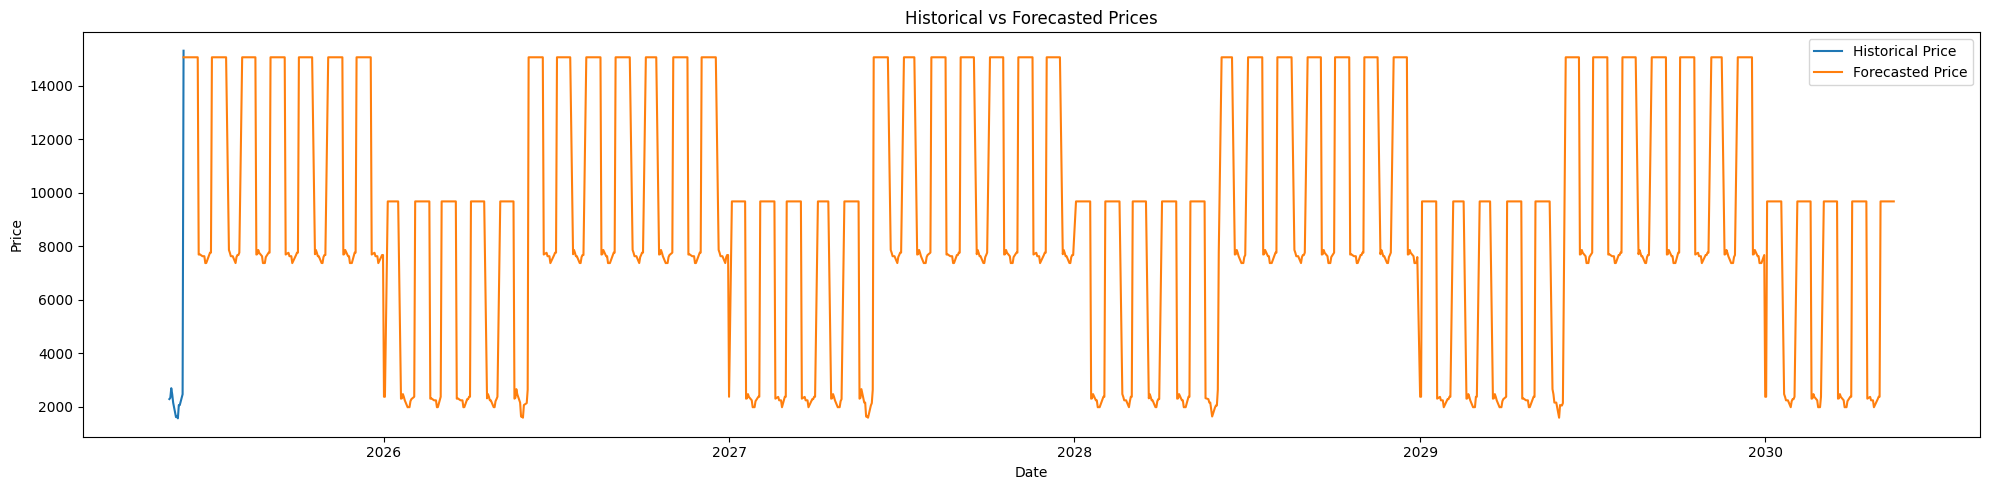

Total forecasted price: 12,078,366.00


In [13]:
#Graph
plt.figure(figsize=(20, 5))
plt.plot(df_feat['date'], df_feat['price'], label='Historical Price')
plt.plot(forecast.index,  forecast,           label='Forecasted Price')
plt.title('Historical vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

total_forecast = forecast.sum()

print(f"Total forecasted price: {total_forecast:,.2f}")

In [14]:
# from statsmodels.tsa.arima.model import ARIMA

# model = ARIMA(y, order=(30, 1, 3))
# model_fit = model.fit(method_kwargs={'maxiter':100, 'disp':False})

# # --- Forecast ---
# n_future_days = x_prediction.shape[0]
# forecast = model_fit.forecast(steps=n_future_days)
# forecast_with_date = x_prediction.copy()

# forecast_with_date['price'] = forecast.values
# forecast = forecast_with_date

# # forecast = pandas.Series(forecast, index=x_prediction.index, name='predicted_price')


In [15]:
# #Graph
# plt.figure(figsize=(20, 5))
# plt.plot(df_feat['date'], df_feat['price'], label='Historical Price')
# plt.plot(forecast.index,  forecast['price'],           label='Forecasted Price')
# plt.title('Historical vs Forecasted Prices')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.tight_layout()
# plt.show()

# total_forecast = (forecast[forecast['price'] > 0])['price'].sum()
# print(f"Total forecasted price: {total_forecast:,.2f}")

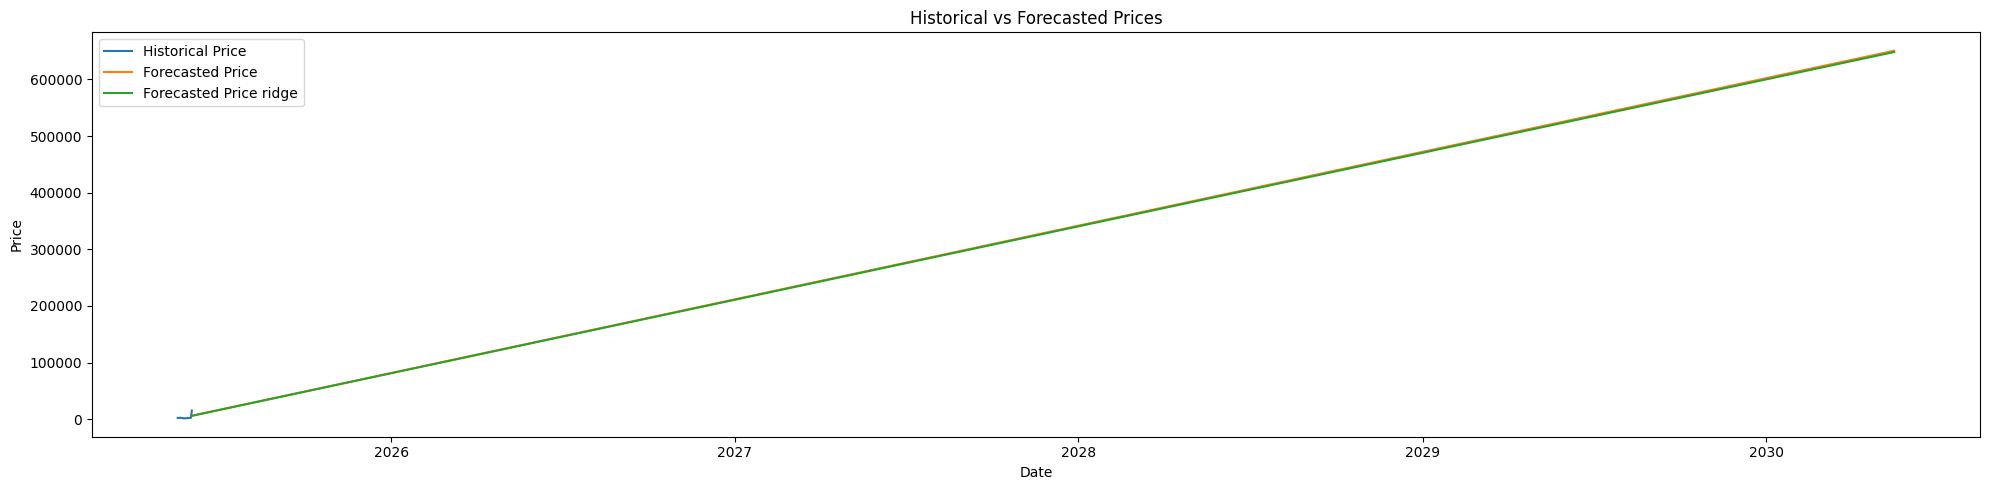

Total forecasted price: 424,952,871.15


In [16]:
from sklearn.linear_model import LinearRegression,Ridge
model = LinearRegression()
ridge_model = Ridge()

selected_featuers = ['days_since_start']

x_train = x[selected_featuers]
x_prediction = predict_df[selected_featuers]

model.fit(x_train, y)
ridge_model.fit(x_train,y)

preds = model.predict(x_prediction)
forecast = pandas.Series(preds, index=x_prediction.index, name='predicted_price')

preds = ridge_model.predict(x_prediction)
forecast_ridge = pandas.Series(preds, index=x_prediction.index, name='predicted_price')

#Graph
plt.figure(figsize=(20, 5))
plt.plot(df_feat['date'], df_feat['price'], label='Historical Price')
plt.plot(forecast.index,  forecast,           label='Forecasted Price')
plt.plot(forecast_ridge.index,  forecast_ridge,           label='Forecasted Price ridge')
plt.title('Historical vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

forecast = forecast[forecast > 0]
total_forecast = forecast.sum()

print(f"Total forecasted price: {total_forecast:,.2f}")